In [1]:
import celeri
import xarray as xr
import pymc as pm
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import linalg
import matplotlib.pyplot as plt
import pytensor.tensor as pt

In [2]:
path = "../data/config/japan_config.json"

In [3]:
model = celeri.build_model(path)
operators = celeri.build_operators(model, eigen=True)

2025-11-24 19:21:50.882 | INFO     | celeri.model:read_data:113 - Reading data files
2025-11-24 19:21:50.888 | SUCCESS  | celeri.model:read_data:126 - Read: /home/adr/git/celeri/data/segment/japan_segment.csv
2025-11-24 19:21:50.890 | SUCCESS  | celeri.model:read_data:131 - Read: /home/adr/git/celeri/data/block/japan_block.csv
2025-11-24 19:21:51.012 | SUCCESS  | celeri.mesh:from_params:681 - Read: /home/adr/git/celeri/data/mesh/nankai.msh
2025-11-24 19:21:51.093 | SUCCESS  | celeri.mesh:from_params:681 - Read: /home/adr/git/celeri/data/mesh/japan.msh
2025-11-24 19:21:51.116 | SUCCESS  | celeri.mesh:from_params:681 - Read: /home/adr/git/celeri/data/mesh/sagami.msh
2025-11-24 19:21:51.122 | SUCCESS  | celeri.mesh:from_params:681 - Read: /home/adr/git/celeri/data/mesh/japan_mock_cmi.msh
2025-11-24 19:21:51.127 | SUCCESS  | celeri.model:read_data:168 - Read: /home/adr/git/celeri/data/station/japan_station.csv
2025-11-24 19:21:51.129 | SUCCESS  | celeri.model:read_data:188 - Read: /home/ad

In [9]:
coords = {
    "station": model.station.index,
    "xyz": ["x", "y", "z"],
    "xy": ["x", "y"],
    "ss_ds": ["ss", "ds"],
    "ss_ds_ts": ["ss", "ds", "ds"],
    "tde_0": pd.RangeIndex(model.meshes[0].n_tde),
    "tde_eigen_0": pd.RangeIndex(model.meshes[0].n_modes),
    "rotation_param": pd.RangeIndex(operators.rotation_to_velocities.shape[1]),
    "time": pd.date_range("2025-01-01", "2025-02-01"),
    "time_coef": pd.RangeIndex(7),
    "earthquake_idx": [15, 23],
}

n_time = len(coords["time"])
n_stations = len(coords["station"])

with pm.Model(coords=coords) as pymc_model:
    rotation = pm.Normal("rotation", dims="rotation_param")
    rotation_vel = 1e-6 * operators.rotation_to_velocities @ rotation
    rotation_vel = pm.Deterministic("rotation_vel", rotation_vel.reshape((n_stations, 3))[:, :2], dims=("station", "xy"))

    # Compute velocities based on time-varying elastic strike slip rates
    # on mesh 0
    if True:
        

        n_tde_eigen = len(coords["tde_eigen_0"])

        # Lazy approximation of the GP covariance with length scale 30,
        # Removing the eigenvalue corresponding to the vector (1,1,1...),
        # because we want to add a mean manually with a different prior.
        ls = 20
        time_days = np.arange(n_time)
        time_cov = np.exp(-(time_days[None, :] - time_days[:, None]) ** 2 / ls ** 2 / 2)
        vals, vecs = linalg.eigh(time_cov, np.eye(n_time) - 0.999 / n_time)
        time_basis = vecs[:, -len(coords["time_coef"]) - 1:-1] * np.sqrt(vals[-len(coords["time_coef"]) - 1:-1])

        # Extract ss to velocity map only
        eigen_to_vel = operators.eigen.eigen_to_velocities[0][:, :model.meshes[0].n_modes]

        # Add a mean to the elastic velocities
        elastic_coefs_mu = pm.Normal("elastic_ss_mean", dims="tde_eigen_0")

        elastic_coefs_time = pm.Normal("elastic_ss_raw", dims=("time_coef", "tde_eigen_0"))
        elastic_coefs_gp = pm.Deterministic(
            "elastic_coefs_ss_0_gp",
            elastic_coefs_time + elastic_coefs_mu[None, :],
            dims=("time_coef", "tde_eigen_0"),
        )

        elastic_vel_gp = pt.einsum("ij,kl,lj", eigen_to_vel, time_basis, elastic_coefs_gp)

        # Earthquake effect
        elastic_coefs_earthquake = pm.Normal(
            "elastic_coefs_ss_0_earthquake",
            dims=("tde_eigen_0", "earthquake_idx"),
        )

        coefs = pt.concatenate([np.zeros((n_tde_eigen, 1)), elastic_coefs_earthquake], axis=1)
        idxs = [0, *coords["earthquake_idx"], n_time]
        elastic_coefs_earthquake_rep = pt.repeat(coefs.cumsum(axis=1), np.diff(idxs), axis=1)
        
        
        elastic_vel_earthquake = pt.einsum("ij,jk->ik", eigen_to_vel, elastic_coefs_earthquake_rep)

        elastic_vel = elastic_vel_gp + elastic_vel_earthquake

        elastic_vel = pm.Deterministic(
            "elastic_vel_ss_0",
            elastic_vel.reshape((n_stations, 2, n_time)),
            dims=("station", "xy", "time"),
        )

        pm.Deterministic(
            "elastic_coefs_ss_0",
            (
                pt.einsum("ij,jk->ki", time_basis, elastic_coefs_gp)
                + elastic_coefs_earthquake_rep
            ),
            dims=("tde_eigen_0", "time")
        )

    mu = (
        rotation_vel[:, :, None]
        + elastic_vel[:, :, :]
    )

    pm.Deterministic("mu", mu, dims=("station", "xy", "time"))

    sigma = pm.HalfNormal("sigma")
    pm.Normal("y_station_vel", mu=mu, sigma=sigma)

In [10]:
with pymc_model:
    tr = pm.sample_prior_predictive(draws=10)

Sampling: [elastic_coefs_ss_0_earthquake, elastic_ss_mean, elastic_ss_raw, rotation, sigma, y_station_vel]


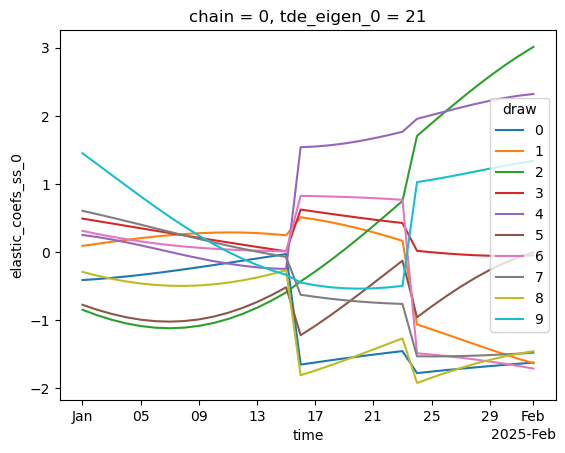

In [11]:
tr.prior.elastic_coefs_ss_0.isel(chain=0).isel(tde_eigen_0=21).plot.line(hue="draw");

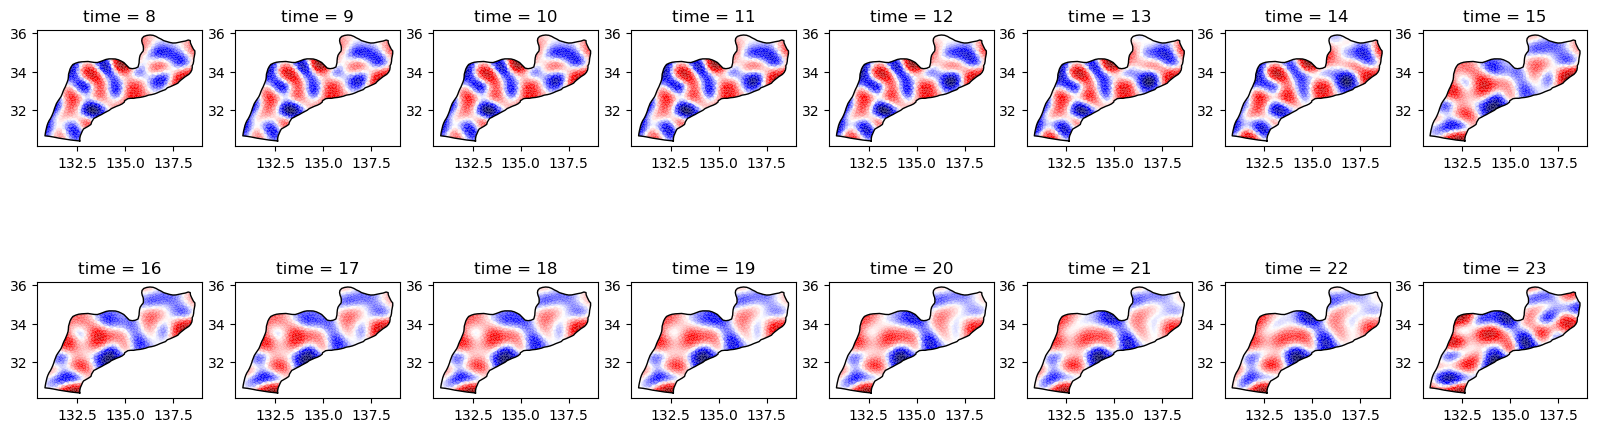

In [41]:
fig, axes = plt.subplots(2, 8, figsize=(20, 6))

for idx, ax in zip(range(8, 12 + 16), axes.flat):
    celeri.plot_mesh(
        model.meshes[0],
        (operators.eigen.eigenvectors_to_tde_slip[0][:, :50] @ tr.prior.elastic_coefs_ss_0.isel(chain=0, draw=5).values)[:, idx][::2],
        ax=ax,
    )
    ax.set_title(f"time = {idx}")
    ax.set_aspect("equal")